In [1]:
!pip install pytorch-transformers

     |████████████████████████████████| 176 kB 1.8 MB/s            


In [2]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

In [3]:
from transformers import AutoModel, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-base")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifie

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)
model.to(device) # Send the model to the GPU if we have one
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

In [5]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

In [6]:
train_data_df = pd.read_csv("../input/boolq-train/SKT_BoolQ_Train.tsv", delimiter='\t')
dev_data_df = pd.read_csv("../input/boolq-dev/SKT_BoolQ_Dev.tsv", delimiter='\t')

train_data_df.columns = ["ID", "passage", "question", "answer"]
dev_data_df.columns = ["ID", "passage", "question", "answer"]

train_data_df.head()

,ID,passage,question,answer
0,1,로마 시대의 오리엔트의 범위는 제국 내에 동부 지방은 물론 제국 외부에 있는 다른 ...,"오리엔트는 인도와 중국, 일본을 이루는 광범위한 지역을 지칭하는 단어로 쓰인다.",1
1,2,비글을 키우려면 비글이 뛰어놀수 있는 넓은 놀이공간 등을 확보하고 있는 단독주택이 ...,비글은 넓고 뚤린 공간에서 키워야 한다.,1
2,3,타이완 요리의 특징은 토속 요리(일본 통치 전)에서 기름을 많이 사용하는 다른 지역...,타이완 요리는 다른 지역의 중국 요리처럼 기름을 많이 사용하는 것이다.,0
3,4,연하곤란은 음식물이 구강에서 식도로 넘어가는 과정에 문제가 생겨 음식을 원활히 혹은...,연하곤란이 생기면 식도가 막히나요?,0
4,5,"인문과학 또는 인문학(人文學, 영어: humanities)은 인간과 인간의 근원문제...",인문과학은 경험적인 접근을 주로 사용하는가?,0


In [7]:
import re

def cleaning(document):
    document = re.sub(r'\((.*?)\)', '', document) 
    # 괄호 ()안에 있는 영어, 한자, 각종 외국어나 설명 제거
    
    return document

In [8]:
# 클리닝 적용
train_data_df["passage"] = train_data_df["passage"].apply(cleaning)
train_data_df["question"] = train_data_df["question"].apply(cleaning)
train_data_df["answer"] = train_data_df["answer"]

dev_data_df["passage"] = dev_data_df["passage"].apply(cleaning)
dev_data_df["question"] = dev_data_df["question"].apply(cleaning)
dev_data_df["answer"] = dev_data_df["answer"]

In [9]:
train_data_df.head()

,ID,passage,question,answer
0,1,로마 시대의 오리엔트의 범위는 제국 내에 동부 지방은 물론 제국 외부에 있는 다른 ...,"오리엔트는 인도와 중국, 일본을 이루는 광범위한 지역을 지칭하는 단어로 쓰인다.",1
1,2,비글을 키우려면 비글이 뛰어놀수 있는 넓은 놀이공간 등을 확보하고 있는 단독주택이 ...,비글은 넓고 뚤린 공간에서 키워야 한다.,1
2,3,타이완 요리의 특징은 토속 요리에서 기름을 많이 사용하는 다른 지역의 중국 요리와 ...,타이완 요리는 다른 지역의 중국 요리처럼 기름을 많이 사용하는 것이다.,0
3,4,연하곤란은 음식물이 구강에서 식도로 넘어가는 과정에 문제가 생겨 음식을 원활히 혹은...,연하곤란이 생기면 식도가 막히나요?,0
4,5,"인문과학 또는 인문학은 인간과 인간의 근원문제, 인간과 인간의 문화에 관심을 갖거나...",인문과학은 경험적인 접근을 주로 사용하는가?,0


In [10]:
passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

In [11]:
# Encoding data
max_seq_length = 512
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [12]:
# Building Dataloaders
batch_size = 8

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [13]:
epochs = 6
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):

  # Training
    epoch_train_loss = 0 # Cumulative loss
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)     

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()
      
        if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)          
    train_loss_values.append(epoch_train_loss)

    # Evaluation
    epoch_dev_accuracy = 0 # Cumulative accuracy
    model.eval()

    for batch in dev_dataloader:
    
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]
                
        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
    
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
    
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)    

Epoch: 100%|██████████| 6/6 [22:07<00:00, 221.30s/it]


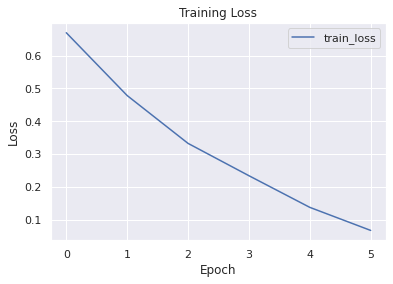

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [15]:
train_loss_values

[0.6694156291178369,
 0.4782696772115163,
 0.33271536859937323,
 0.23433925346968482,
 0.138020802147723,
 0.06782942363324784]

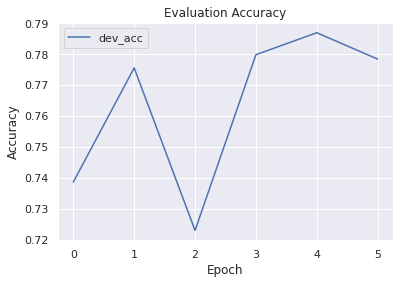

In [16]:
plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.show()

In [17]:
dev_acc_values

[0.7386363636363636,
 0.7755681818181818,
 0.7230113636363636,
 0.7798295454545454,
 0.7869318181818182,
 0.7784090909090909]